In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [138]:
def newton(func, goal, initial_guess, tol, max_iterations=100, **kwargs):
    x = initial_guess
    f, df = func(x, **kwargs)
    iterations = 0
    while np.linalg.norm(f - goal) > tol and iterations < max_iterations:
        iterations += 1
        x -= np.linalg.solve(df, f)
        f, df = func(x, **kwargs)
    return x

In [103]:
def gradient_descent(func, goal, initial_guess, speed, tol, max_iterations = 1000, **kwargs):
    x = initial_guess
    f, df = func(x, **kwargs)
    grad_f = np.dot(df.T, f - goal)
    iterations = 0
    while np.linalg.norm(f - goal) and iterations < max_iterations:
        iterations += 1
        x -= speed*grad_f
        f, df = func(x, **kwargs)
        grad_f = np.dot(df.T, f - goal)
    return x

In [144]:
def momentum_descent(func, goal, initial_guess, speed, tol, decay=0.8, max_iterations = 1000, **kwargs):
    x = initial_guess
    p = np.zeros(x.shape)
    f, df = func(x, **kwargs)
    grad_f = np.dot(df.T, f - goal)
    iterations = 0
    while np.linalg.norm(f - goal) and iterations < max_iterations:
        iterations += 1
        p = decay*p + grad_f
        x -= speed*p
        f, df = func(x, **kwargs)
        grad_f = np.dot(df.T, f - goal)
    return x

In [43]:
def rk2(func, x0, t0, tf, dt, **kwargs):
    n = int(np.ceil((tf - t0)/dt))
    m = len(x0)
    X = np.empty((n,m))
    X[0,:] = x0
    T = np.linspace(t0, tf, n)
    
    if kwargs["compute_derivatives"]:
        derivs = np.eye(m)
    
    for i in xrange(1,n):
        if kwargs["compute_derivatives"]:
            k1, j1 = func(X[i-1,:], T[i-1], **kwargs)
            k2, j2 = func(X[i-1,:], T[i-1], **kwargs)
            derivs += dt*np.linalg.multi_dot([
                    j2,
                    (np.eye(m) + 0.5*dt*j1),
                    derivs
                ])
        else:
            k1 = func(X[i-1,:], T[i-1], **kwargs)
            k2 = func(X[i-1,:] + 0.5*dt*k1, T[i-1] + 0.5*dt, **kwargs)
        X[i, :] = X[i-1,:] + dt*k2
            
    if kwargs["compute_derivatives"]:
        return {"T": T, "X": X, "derivs": derivs}
    else:
        return {"T": T, "X":X}

In [44]:
def harmonic(x, t, frequency=1.0, compute_derivatives=False):
    deriv = np.array([x[1], -frequency**2*x[0]])
    if compute_derivatives:
        jacobian = np.array([[0, 1],[-frequency**2, 0]])
        return deriv, jacobian
    else:
        return deriv    

In [69]:
def harmonic_with_force(x, t, w=1.0, m=1.0, compute_derivatives=False):
    f = x[1]/m - x[3]
    
    deriv = np.array([
        x[1]/m, 
        -m*w**2*x[0] + f, 
        m*w**2*x[3], 
        f/m - x[2]/m])
    
    if compute_derivatives:
        jacobian = np.array([
            [0, 1/m, 0, 0],
            [-m*w**2, 1/m, 0, -1],
            [0, 0, 0, m*w**2],
            [0, m**(-2), -1/m, -1/m]])
        return deriv, jacobian
    else:
        return deriv    

In [145]:
def momentum_for_point_in_time(initial_conditions, final_conditions, time, speed, **kwargs):

    def newton_interface(x):
        
        result = rk2(harmonic_with_force, 
            np.array([0.0, 1.0, x[0], x[1]]), 
            0.0, time, 0.01, 
            w = 1.0,
            m = 1.0,
            compute_derivatives=True)
        plt.plot(result["T"], result["X"][:,0])
        f = result["X"][-1,:2]
        df = result["derivs"][:2,2:]
        return f, df
    
    init_params = momentum_descent(
        newton_interface,
        final_conditions,
        np.array([0.0, 0.0]),
        speed,
        1e-10,
        **kwargs)
    
    return init_params

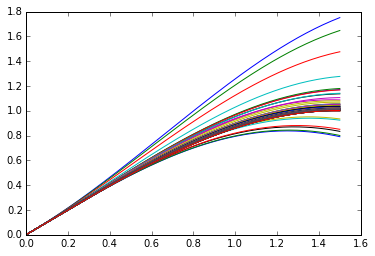

In [146]:
phi_inits = momentum_for_point_in_time(
    np.array([0.0, 1.0]),
    np.array([1.0, 0.0]),
    1.5,
    0.1,
    max_iterations=100)

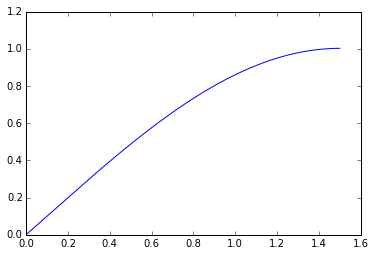

In [147]:
result = rk2(harmonic_with_force, 
    np.array([0.0, 1.0, phi_inits[0], phi_inits[1]]), 
    0.0, 1.5, 0.01, 
    w = 1.0,
    m = 1.0,
    compute_derivatives=True)
T = result["T"]
X = result["X"]
plt.plot(T, X[:,0])

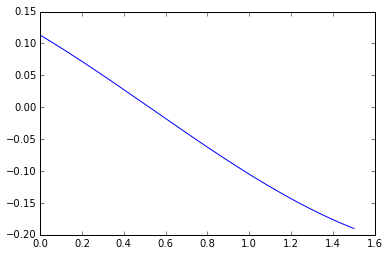

In [148]:
plt.plot(result["T"], result["X"][:,1]/1.0 - result["X"][:,3])

### Rocket Problem

In [163]:
m = 1.0
g = 9.8
f = 5.0*g
control_start_time = 0.05
control_start_angle = 0.49*np.pi
inits = np.array([
        0.5*f/m*np.cos(control_start_angle)*control_start_time**2,
        0.5*(f/m*np.sin(control_start_angle) - g)*control_start_time**2,
        (f/m*np.cos(control_start_angle))*control_start_time,
        (f/m*np.sin(control_start_angle)-g)*control_start_time
    ])

In [207]:
def rocket_gravity_turn(x, t, m=1.0, g=9.8, f=20.0, compute_derivatives=False):
    
    tan_phi = x[3]/x[2]
    cos_phi = 1.0/np.sqrt(1 + tan_phi**2)
    sin_phi = tan_phi * cos_phi
    
    deriv = np.array([
        x[2]/m, x[3]/m,
        f/m*cos_phi, f/m*sin_phi - m*g
    ])
    
    if compute_derivatives:
        d_cos_phi_d_tan_phi = -cos_phi/(1 + tan_phi**2)
        d_sin_phi_d_tan_phi = tan_phi*d_cos_phi_d_tan_phi + cos_phi
        
        d_tan_phi_d_p_x = -tan_phi/x[2]
        d_tan_phi_d_p_y = 1.0/x[2]
        
        d_cos_phi_d_p_x = d_cos_phi_d_tan_phi*d_tan_phi_d_p_x
        d_cos_phi_d_p_y = d_cos_phi_d_tan_phi*d_tan_phi_d_p_y
        d_sin_phi_d_p_x = d_sin_phi_d_tan_phi*d_tan_phi_d_p_x
        d_sin_phi_d_p_y = d_sin_phi_d_tan_phi*d_tan_phi_d_p_y
        
        jac = np.array([
                [0.0, 0.0, 1.0/m, 0.0],
                [0.0, 0.0, 0.0, 1.0/m],
                [0.0, 0.0, f*d_cos_phi_d_p_x, f*d_cos_phi_d_p_y],
                [0.0, 0.0, f*d_sin_phi_d_p_x, f*d_sin_phi_d_p_y]
            ])
        return deriv, jac
    else:
        return deriv

In [208]:
result = rk2(rocket_gravity_turn,
   inits,
   control_start_time, 10.0, 0.01,
   compute_derivatives=False)

In [209]:
final_position = result["X"][-1,:]

In [210]:
final_position

array([ 499.42250688,  328.87798087,  129.819676  ,   38.13137181])

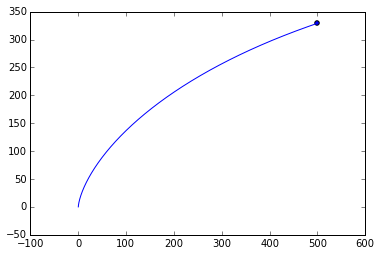

In [212]:
plt.plot(result["X"][:,0],result["X"][:,1])
plt.scatter([final_position[0]], [final_position[1]])

In [213]:
def rocket(x, t, m=1.0, g=9.8, f=50.0, compute_derivatives=False):
    
    tan_phi_numerator = x[3] - m*x[7]
    tan_phi_denominator = x[2] - m*x[6]
    tan_phi = tan_phi_numerator/tan_phi_denominator
    cos_phi = 1.0/np.sqrt(1 + tan_phi**2)
    sin_phi = tan_phi * cos_phi
    
    deriv = np.array([x[2]/m, x[3]/m,
             f*cos_phi, f*sin_phi - m*g,
             0.0, 0.0,
             f/m*cos_phi - x[4]/m, f/m*sin_phi - x[5]/m])
    
    if compute_derivatives:
        d_cos_phi_d_tan_phi = -cos_phi/(1 + tan_phi**2)
        d_sin_phi_d_tan_phi = tan_phi*d_cos_phi_d_tan_phi + cos_phi
        
        d_tan_phi_d_p_x = -tan_phi/tan_phi_denominator
        d_tan_phi_d_p_y = 1.0/tan_phi_denominator
        d_tan_phi_d_psi_p_x = m*tan_phi/tan_phi_denominator
        d_tan_phi_d_psi_p_y = -m/tan_phi_denominator
        
        d_cos_phi_d_p_x = d_cos_phi_d_tan_phi*d_tan_phi_d_p_x
        d_cos_phi_d_p_y = d_cos_phi_d_tan_phi*d_tan_phi_d_p_y
        d_cos_phi_d_psi_p_x = d_cos_phi_d_tan_phi*d_tan_phi_d_psi_p_x
        d_cos_phi_d_psi_p_y = d_cos_phi_d_tan_phi*d_tan_phi_d_psi_p_y
        d_sin_phi_d_p_x = d_sin_phi_d_tan_phi*d_tan_phi_d_p_x
        d_sin_phi_d_p_y = d_sin_phi_d_tan_phi*d_tan_phi_d_p_y
        d_sin_phi_d_psi_p_x = d_sin_phi_d_tan_phi*d_tan_phi_d_psi_p_x
        d_sin_phi_d_psi_p_y = d_sin_phi_d_tan_phi*d_tan_phi_d_psi_p_y
        
        jac = np.array([
                [0, 0, 1/m, 0, 0, 0, 0, 0],
                [0, 0, 0, 1/m, 0, 0, 0, 0],
                [0, 0, f*d_cos_phi_d_p_x, f*d_cos_phi_d_p_y, 
                    0,0, f*d_cos_phi_d_psi_p_x, f*d_cos_phi_d_psi_p_y],
                [0, 0, f*d_sin_phi_d_p_x, f*d_sin_phi_d_p_y, 
                    0,0, f*d_sin_phi_d_psi_p_x, f*d_sin_phi_d_psi_p_y],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, f*d_cos_phi_d_p_x, f*d_cos_phi_d_p_y, 
                    -1/m, 0, f*d_cos_phi_d_psi_p_x, f*d_cos_phi_d_psi_p_y],
                [0, 0, f*d_sin_phi_d_p_x, f*d_sin_phi_d_p_y, 
                    0, -1/m, f*d_sin_phi_d_psi_p_x, f*d_sin_phi_d_psi_p_y]])
        return deriv, jac
    else:
        return deriv

In [214]:
def newton_interface(x, inits=np.zeros(4), max_time=4.0, dt=0.01):
    result = rk2(rocket,
        np.array([inits[0], inits[1], inits[2], inits[3],
            x[0], x[1], x[2], x[3]]),
        0.0, max_time, dt,
        m=m, g=g, f=f,
        compute_derivatives=True)
    return result["X"][-1,:4], result["derivs"][:4, 4:]    

In [249]:
init_params = momentum_descent(
    newton_interface,
    final_position,
    np.array([15.0, 10.0, 30, inits[3]/m + np.tan(control_start_angle)*(30 - inits[2]/m)]),
    0.1,
    1e-10,
    inits=inits,
    max_time=4.0,
    dt=0.01)

In [250]:
init_params

array([ 21336.26063623,   1946.83604858, -11252.27831305,  -1103.01298255])

In [251]:
good_inits = np.array([
        inits[0], inits[1], inits[2], inits[3],
        init_params[0], init_params[1], init_params[2], init_params[3]
    ])

In [252]:
good_result = rk2(
    rocket,
    good_inits,
    0.0, 4.0, 0.01,
    m=m, g=g, f=f,
    compute_derivatives=False)


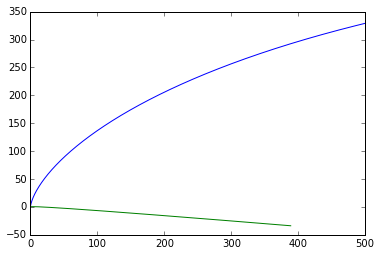

In [253]:
plt.plot(result["X"][:,0],result["X"][:,1])
plt.plot(good_result["X"][:,0], good_result["X"][:,1])

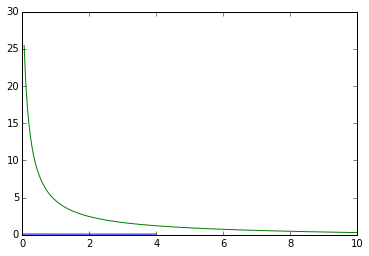

In [254]:
tan_theta = (good_result["X"][:,3] - m*good_result["X"][:,7])/(good_result["X"][:,2] - m*good_result["X"][:,6])
plt.plot(good_result["T"], tan_theta)
plt.plot(result["T"], result["X"][:,3]/result["X"][:,2])

In [ ]:
(p_y - m psi_p_y)/(p_x - m_psi_p_x) = tantheta
py - m ppy = tantheta (px - m ppx)
ppy = py/m + tantheta ( ppx - px/m)